## Testing the irrigated extents MaxNDVI workflow

multithreaded version below 18/4/19

In [14]:
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd
from osgeo import gdal, ogr
import os
from multiprocessing import Pool
from rsgislib.segmentation import segutils
from rsgislib.segmentation import tiledsegsingle

import datacube 
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.utils import geometry

#import custom functions
import sys
sys.path.append('src')
import DEAPlotting, SpatialTools
from transform_tuple import transform_tuple

In [11]:
# import fiona
# from shapely.geometry import shape
# from shapely.geometry import mapping

# df1 = fiona.open("results/nmdb_plots/shapes/interim/2002_2004/CONDAMINE-CULGOA RIVERS_2002_2004.shp")

# df2 = fiona.open("results/nmdb_plots/shapes/interim/2005_2007/CONDAMINE-CULGOA RIVERS_2005_2007.shp") 

# schema = {'geometry': 'Polygon','properties': {'irr': 'int'}}
# with fiona.open('diff.shp','w','ESRI Shapefile', schema) as e:
#      for geom in [shape(i['geometry']).difference(shape(j['geometry'])) for i,j in zip(list(df2),list(df1))]:
#                 if geom.is_valid==False:
#                     geom.buffer(0.0)
#                 if not geom.is_empty:
#                                e.write({'geometry':mapping(geom), 'properties':{'irr':1}})

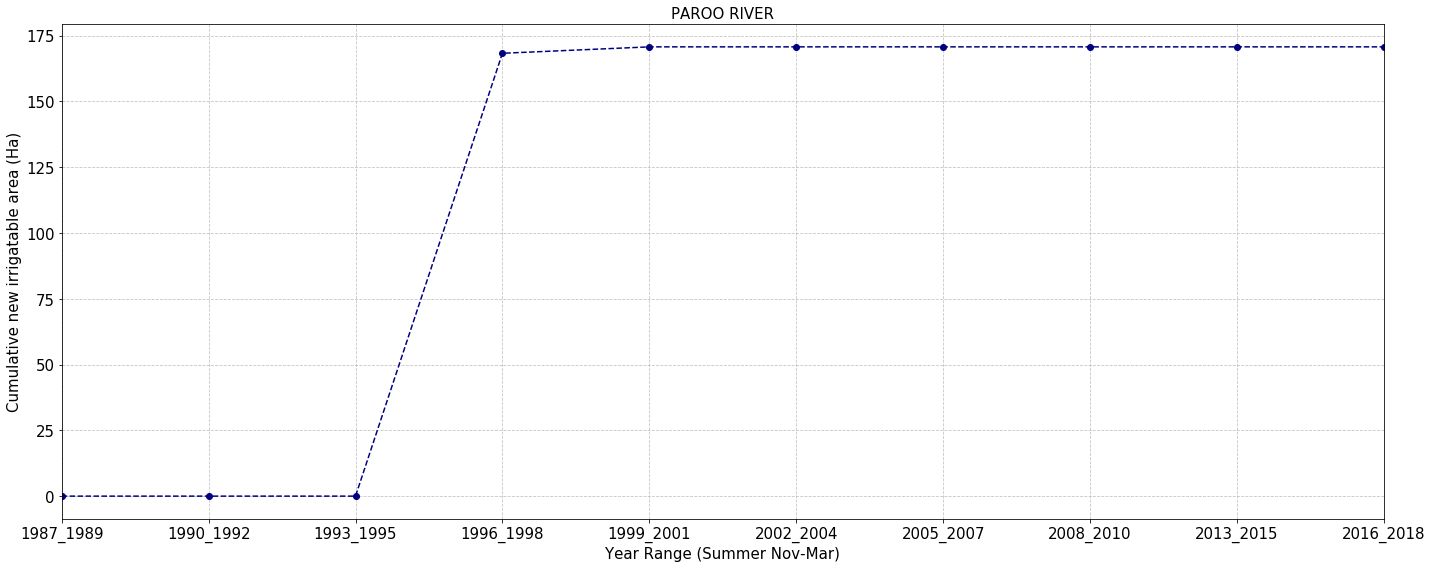

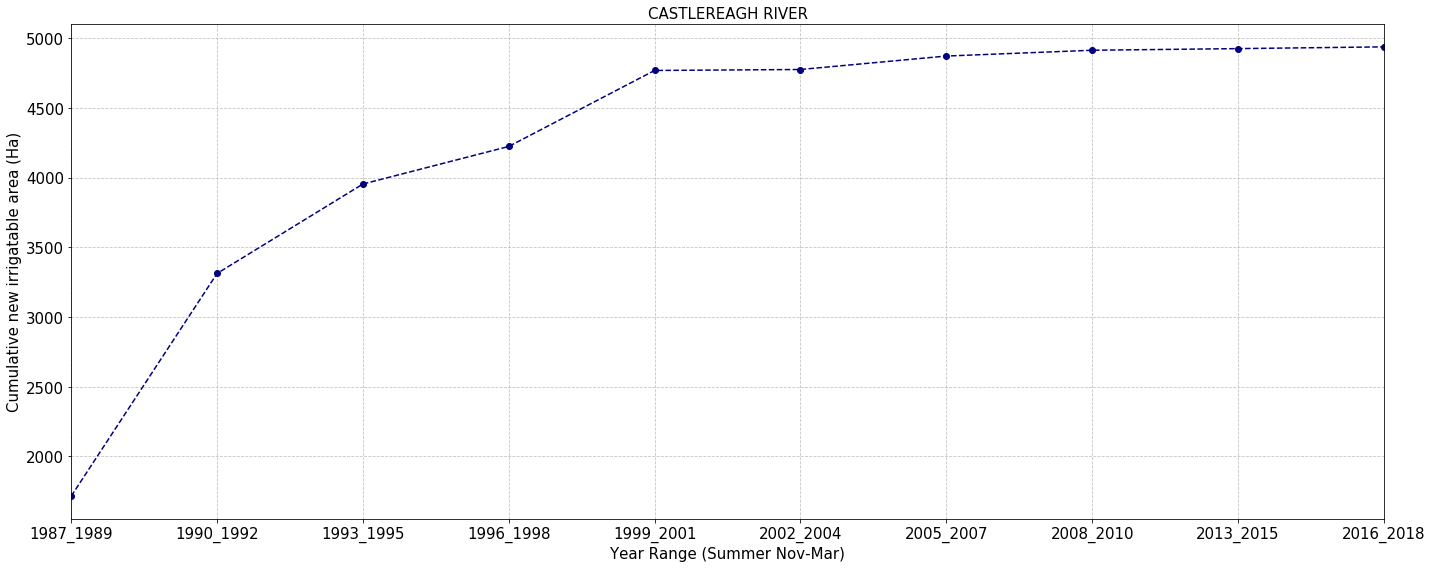

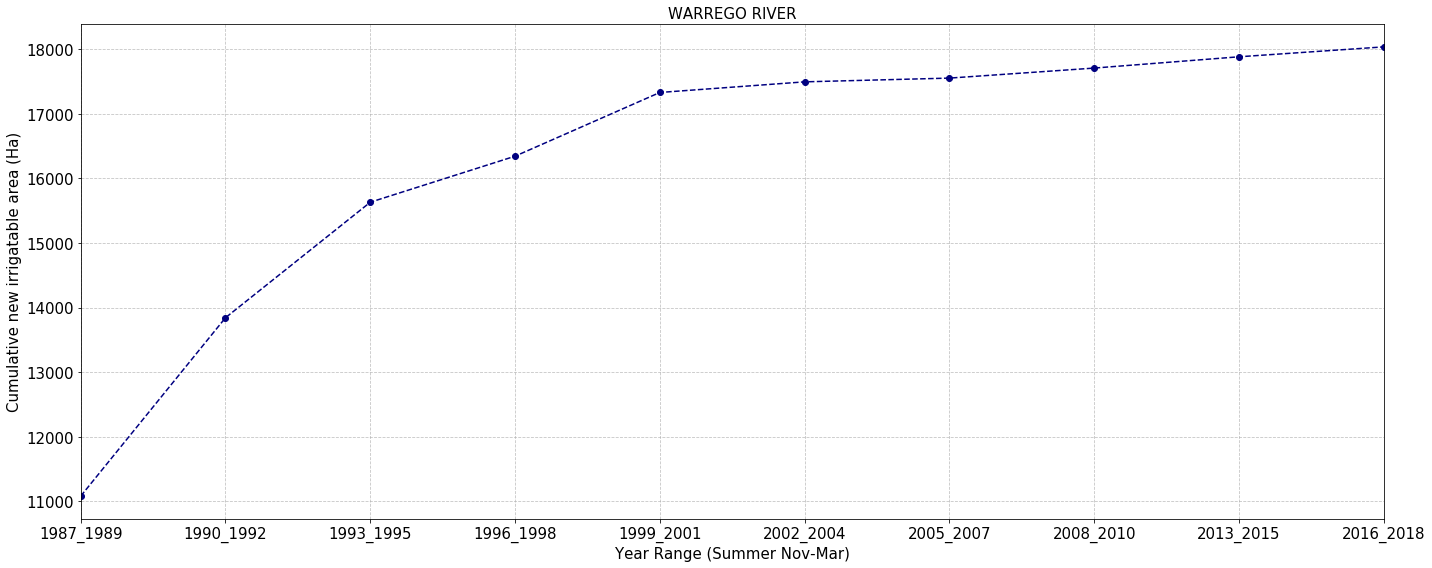

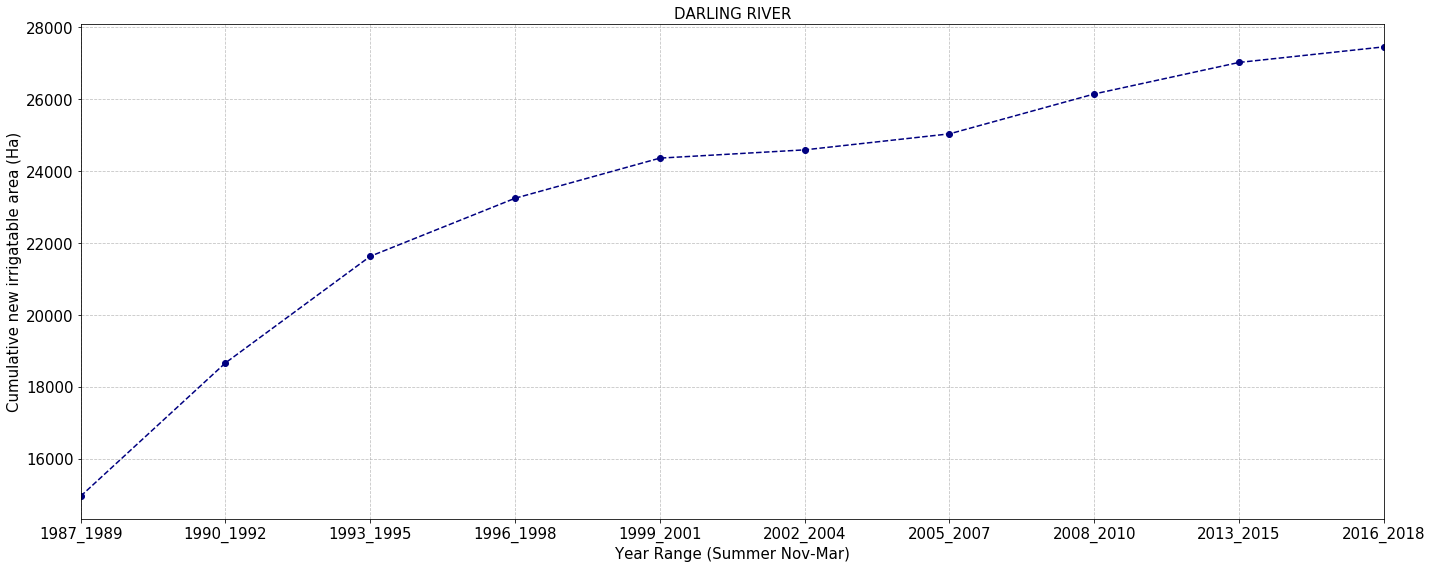

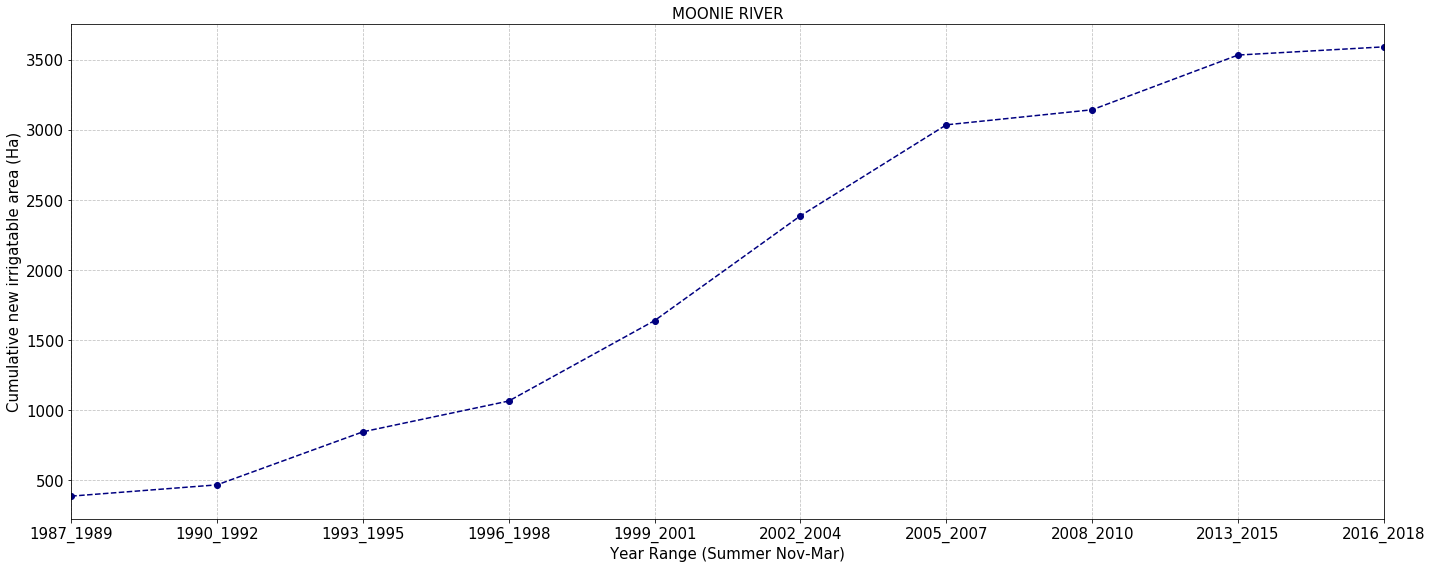

In [41]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
folder = "/g/data/r78/cb3058/dea-notebooks/ICE_project/results/nmdb_plots/csvs/"
yearstrings = ['1987_1989','1990_1992', '1993_1995',
                '1996_1998', '1999_2001', '2002_2004',
                '2005_2007', '2008_2010', '2013_2015', '2016_2018'] 

for file in os.listdir(folder):
    fontsize = 15
    df = pd.read_csv(folder+file, index_col=0)
    ax = df.plot(colormap='jet', linestyle='--', marker='o',legend = False, figsize=(20,8))
    ax.set_xlabel('Year Range (Summer Nov-Mar)', fontsize=fontsize)
    ax.set_ylabel('Cumulative new irrigatable area (Ha)', fontsize=fontsize)
    ax.grid(True, linestyle='--', alpha=0.75)
    ax.set_title(file[:-20],fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)
    plt.tight_layout()
#     plt.savefig("/g/data1a/r78/cb3058/dea-notebooks/ICE_project/results/nmdb_plots/"+ catchment[85:-4]+".pdf",
#                orientation='landscape') 

In [2]:
tif = "/g/data1a/r78/cb3058/dea-notebooks/dcStats/results/nmdb/nmdb_Summer2016_17_NDVI_max.tif"

In [3]:
NDVI_max = xr.open_rasterio(tif).squeeze()

In [5]:
gdal_dataset = gdal.Open(tif)
out_array = gdal_dataset.GetRasterBand(1).ReadAsArray()
transform_gdal= gdal_dataset.GetGeoTransform()
projection_gdal = gdal_dataset.GetProjection()
shape_gdal = out_array.shape

In [10]:
transform, projection = transform_tuple(NDVI_max, (NDVI_max.x, NDVI_max.y), epsg=3577)

In [ ]:
gdal_dataset

In [7]:
print(transform_gdal)

(853937.5, 25.0, 0.0, -2742812.5, 0.0, -25.0)


In [11]:
print(transform)

(853937.5, 25.0, 0.0, -2742812.5, 0.0, -25.0)


In [9]:
NDVI_max.transform

(25.0, 0.0, 853937.5, 0.0, -25.0, -2742812.5)

In [ ]:
shape_gdal

In [ ]:
NDVI_max.shape

In [ ]:
print(projection_gdal)

In [ ]:
print(projection)

In [ ]:
NDVI_max

In [ ]:
"/g/data/r78/cb3058/dea-notebooks/ICE_project/data/spatial/renmark.shp"

In [1]:
x = range(2013,2014,1)
years = []
for i in x:
    nextyear = str(i + 1)[2:]
    y = str(i) + "_" + nextyear
    years.append(str(y))
years =  [e for e in years if e not in ('2011_12', '2012_13')]
years.sort()

In [6]:
folders = os.listdir("/g/data/r78/cb3058/dea-notebooks/ICE_project/results/nmdb/" )
folders.sort()

In [10]:
folders[24]

'nmdb_Summer2013_14'

In [ ]:
cpus=4
mask_dir = "/g/data/r78/cb3058/dea-notebooks/ICE_project/data/spatial/nmdb_80mask_allDryYears_merged.shp"

In [ ]:
x = range(1987,2019,1)
years = []
for i in x:
    nextyear = str(i + 1)[2:]
    y = str(i) + "_" + nextyear
    years.append(str(y))
years.sort()
    
directory = "/g/data/r78/cb3058/dea-notebooks/ICE_project/results/nmdb/"    
folders = os.listdir(directory)
folders.sort()

inputs=[]
for year, folder in zip(years, folders):
    inputs.append(directory+folder+"/"+"nmdb_Summer"+ year + "_multithreshold.tif")
inputs.sort()

In [ ]:
def clip_tiff(tif):
#     print(tif[:-19])
    a = xr.open_rasterio(tif).squeeze()
    transform, projection = transform_tuple(a, (a.x, a.y), epsg=3577)
    width,height = a.shape
    mask = SpatialTools.rasterize_vector(mask_dir,
           height, width, transform, projection, raster_path=None)
    b = a.where(mask)
    SpatialTools.array_to_geotiff(tif[:-4]+"_masked.tif",
              b.values, geo_transform = transform, 
              projection = projection, 
              nodata_val=np.nan)
    os.system('gdal_polygonize.py ' + tif[:-4]+"_masked.tif" + ' -f' + ' ' + '"ESRI Shapefile"' + ' ' + tif[:-4]+"_masked.shp")
    gdf = gpd.read_file(tif[:-4]+"_masked.shp")
    gdf['area'] = gdf['geometry'].area
    gdf.to_file(tif[:-4]+"_maskedwArea.shp")
    print("finished processing: "+tif[88:-19])

pool = Pool(cpus)
pool.map(clip_tiff, inputs) 

In [ ]:
############
#User Inputs
############

# where are the dcStats MaxNDVI tifs?
MaxNDVItiffs = "/g/data/r78/cb3058/dea-notebooks/dcStats/results/mdb_NSW/New folder/maxndvi/"

# where are the dcStats NDVIArgMaxMin tifs?
NDVIArgMaxMintiffs = "/g/data/r78/cb3058/dea-notebooks/dcStats/results/mdb_NSW/New folder/argmaxndvi/"

# where should I put the results?
results = '/g/data/r78/cb3058/dea-notebooks/dcStats/results/mdb_NSW/summer/previous_run/testing_mosaics/results/'

#what season are we processing?
season = 'Summer'

#Input your area of interest's name
AOI = 'rsgislibe_test_tiled'

In [ ]:
def irrigated_extent(tif):
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print("starting processing of " + tif)
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    results_ = results
    if season == 'Summer':
        year = tif[9:13]
        nextyear = str(int(year) + 1)[2:] 
        year = year + "_" + nextyear
        year = season + year
        argmaxminyear = "NDVIArgMaxMin_" + year[6:10] + "1101.tif" 
    if season == 'Winter':
        year = tif[7:11]
        year = season + year
        argmaxminyear = "NDVIArgMaxMin_" + year[6:10] + "0501.tif" 

    #Creating a folder to keep things neat
    directory = results_ + AOI + "_" + year
    if not os.path.exists(directory):
        os.mkdir(directory)

    results_ = results_ + AOI + "_" + year + "/"
    
    #inputs to GDAL and RSGISlib
    InputNDVIStats = MaxNDVItiffs + tif
    KEAFile = results_ + AOI + '_' + year + '.kea'
    SegmentedKEAFile = results_ + AOI + '_' + year + '_sheperdSEG.kea'
    meanImage = results_ + AOI + '_' + year + "_ClumpMean.kea"
     
    # Change the tiff to a kea file
    gdal.Translate(KEAFile, InputNDVIStats, format='KEA', outputSRS='EPSG:3577')
    
    # Run segmentation, with creation of clump means
#     segutils.runShepherdSegmentation(KEAFile, SegmentedKEAFile,
#                         meanImage, numClusters=20, minPxls=100)

    tiledsegsingle.performTiledSegmentation(KEAFile, SegmentedKEAFile, tmpDIR='./tiledsegtmp'+year,
                                        tileWidth=1000, tileHeight=1000, minPxls=100)
    
    print('done')
#     segment_means= xr.open_rasterio(meanImage).squeeze()
    
#     #reclassify and threshold by different values
#     a = np.where(segment_means.values>=0.8, 80, segment_means)
#     b = np.where((a>=0.75) & (a<0.8), 75, a)
#     c = np.where((b>=0.70) & (b<0.75), 70, b)
#     d = np.where(c>=70, c, np.nan)
    
#     print('exporting the multithreshold as Gtiff')
#     transform, projection = transform_tuple(segment_means, (segment_means.x, segment_means.y), epsg=3577)
#     #find the width and height of the xarray dataset we want to mask
#     width,height = segment_means.shape
    
#     SpatialTools.array_to_geotiff(results_ + AOI + "_" + year + "_multithreshold.tif",
#                   d, geo_transform = transform, 
#                   projection = projection, 
#                   nodata_val=np.nan)
    
#     #converting irrigated areas results to polygons
#     print('converting multithreshold tiff to polygons...')
#     multithresholdTIFF = results_ + AOI + "_" + year + "_multithreshold.tif"
#     multithresholdPolygons = results_ + AOI + '_' + year + '_multithreshold.shp'
    
#     os.system('gdal_polygonize.py ' + multithresholdTIFF + ' -f' + ' ' + '"ESRI Shapefile"' + ' ' + multithresholdPolygons)
    
#     #filter by the area of the polygons to get rid of any forests etc
#     print('filtering polygons by size, exporting, then rasterizing')
#     gdf = gpd.read_file(multithresholdPolygons)
#     gdf['area'] = gdf['geometry'].area
#     smallArea = gdf['area'] <= 10000000
#     gdf = gdf[smallArea]
#     #export shapefile
#     gdf.to_file(results_ + AOI + "_" + year + "_Irrigated.shp")
    
#     gdf_raster = SpatialTools.rasterize_vector(results_ + AOI + "_" + year + "_Irrigated.shp",
#                                                height, width, transform, projection, raster_path=None)
    
#     print('loading, then masking timeof rasters')
#     argmaxmin = xr.open_rasterio(NDVIArgMaxMintiffs+argmaxminyear)
#     timeofmax = argmaxmin[0] 
#     timeofmin = argmaxmin[1]

#     # mask timeof layers by irrigated extent
#     timeofmax = timeofmax.where(gdf_raster)
#     timeofmin = timeofmin.where(gdf_raster)

#     # export masked timeof layers.
#     print('exporting the timeofmaxmin Gtiffs')
#     SpatialTools.array_to_geotiff(results_ + AOI + "_" + year + "_timeofmaxNDVI.tif",
#                   timeofmax.values,
#                   geo_transform = transform, 
#                   projection = projection, 
#                   nodata_val=-9999)

#     SpatialTools.array_to_geotiff(results_ + AOI + "_" + year + "_timeofminNDVI.tif",
#                   timeofmin.values,
#                   geo_transform = transform, 
#                   projection = projection, 
#                   nodata_val=-9999)
    

In [ ]:
maxNDVItiffFiles = os.listdir(MaxNDVItiffs)

if __name__ == '__main__':
    pool = Pool(os.cpu_count()-5)  #use 3 cpus on vdi
    pool.map(irrigated_extent, maxNDVItiffFiles)

In [ ]:
maxNDVItiffFiles = os.listdir(MaxNDVItiffs)

irrigated_extent(maxNDVItiffFiles[0])



In [ ]:
data = xr.open_rasterio('path/to/data').squeeze()
area = np.count_nonzero(~np.isnan(data.values))*(25*25) / 10000
area

In [2]:
#generate list of inputs for GNU parallel
import os
maxNDVItiffFiles = os.listdir("/g/data/r78/cb3058/dea-notebooks/dcStats/results/renmark")
maxNDVItiffFiles.sort()
with open('renmark_maxNDVItiffFiles.txt', 'w') as f:
    for item in maxNDVItiffFiles:
        f.write("%s\n" % item)

In [ ]:
tiff = "/g/data1a/r78/cb3058/dea-notebooks/ICE_project/results/renmark/renmark_Summer2016_17/renmark_Summer2016_17_multithreshold_irrigated.tif"

In [ ]:
NDVI_max_Irrigated = xr.open_rasterio(tiff).squeeze()
# NDVI_max_Irrigated.plot(figsize=(20,16))

In [ ]:
width,height = NDVI_max_Irrigated.shape
transform, projection = transform_tuple(NDVI_max_Irrigated, (NDVI_max_Irrigated.x, NDVI_max_Irrigated.y), epsg=3577)

In [ ]:
#remove pixels that cross over the major rivers in the region
rivers_raster = SpatialTools.rasterize_vector("data/spatial/major_rivers_aus.shp", height, width, transform, projection, raster_path=None)
rivers_raster = rivers_raster.astype(bool)
from scipy.ndimage.morphology import binary_dilation as bd
rivers_raster = bd(rivers_raster)

rivers_raster = xr.DataArray(rivers_raster, coords = [NDVI_max_Irrigated.y, NDVI_max_Irrigated.x], dims = ['y', 'x'], name='rivers')
masked_irr = NDVI_max_Irrigated.where(rivers_raster == 0)

In [ ]:
# masked_irr.plot(figsize=(20,16))

In [ ]:
ones = np.count_nonzero((~np.isnan(masked_irr.values)))
area = (ones*(25*25)) / 1000000
print(str(area) + " km2 was under irrigated cultivation")

In [ ]:
ones = np.count_nonzero((~np.isnan(NDVI_max_Irrigated.values)))
area = (ones*(25*25)) / 1000000
print(str(area) + " km2 was under irrigated cultivation")

In [ ]:
transform, projection = transform_tuple(a, (a.x, a.y), epsg=3577)
#find the width and height of the xarray dataset we want to mask
width,height = a.shape

SpatialTools.array_to_geotiff("/g/data/r78/cb3058/dea-notebooks/ICE_project/results/renmark/renmark_Summer2015_16/renmark_Summer2015_16_ClumpMean.tif",
              a.values, geo_transform = transform, 
              projection = projection, 
              nodata_val=np.nan)

In [ ]:
a

In [ ]:
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd
from osgeo import gdal, ogr
import os
from multiprocessing import Pool, cpu_count
from rsgislib.segmentation import segutils

import datacube 
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.utils import geometry

#import custom functions
import sys
sys.path.append('src')
import DEAPlotting, SpatialTools
from transform_tuple import transform_tuple

############
#User Inputs
############

#how many cpus should the job be distrubuted over?
# cpus = 8

# where are the dcStats MaxNDVI tifs?
MaxNDVItiffs = "/g/data/r78/cb3058/dea-notebooks/dcStats/results/mdb_NSW/summer/ndvi_max/mosaics/"

# where are the dcStats NDVIArgMaxMin tifs?
NDVIArgMaxMintiffs = "/g/data/r78/cb3058/dea-notebooks/dcStats/results/mdb_NSW/summer/ndviArgMaxMin/mosaics"

#Is there an irrigatable area shapefile we're using for masking?
# irrigatable_area = False
# irrigatable_area_shp_fpath = "/g/data/r78/cb3058/dea-notebooks/ICE_project/data/spatial/NSW_OEH_irrigated_2013.shp"

#Shapefile we're using for clipping the extent? e.g. just the northern basins
northernBasins_shp = "/g/data/r78/cb3058/dea-notebooks/ICE_project/data/spatial/northern_basins.shp"

# where should I put the results?
results = '/g/data/r78/cb3058/dea-notebooks/ICE_project/results/nmdb/'

#what season are we processing (Must be 'Summmer' or 'Winter')?
season = 'Summer'

#Input your area of interest's name
AOI = 'nmdb'

# script proper-----------------------------

def irrigated_extent(tif):
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print("starting processing of " + tif)
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    results_ = results
    
    if season == 'Summer':
        year = tif[9:13]
        nextyear = str(int(year) + 1)[2:] 
        year = year + "_" + nextyear
        year = season + year
        argmaxminyear = "ndviArgMaxMin_" + year[6:10] + "1101_mosaic.tif" 
    if season == 'Winter':
        year = tif[7:11]
        year = season + year
        argmaxminyear = "ndviArgMaxMin_" + year[6:10] + "0501_mosaic.tif" 

    #Creating a folder to keep things neat
    directory = results_ + AOI + "_" + year
    if not os.path.exists(directory):
        os.mkdir(directory)

    results_ = results_ + AOI + "_" + year + "/"
    
    #limiting the extent to the northern basins
    print('clipping extent to provided polygon')
    NDVI_max = xr.open_rasterio(MaxNDVItiffs + tif).squeeze()

    transform, projection = transform_tuple(NDVI_max, (NDVI_max.x, NDVI_max.y), epsg=3577)
    width,height = NDVI_max.shape

    clip_raster = SpatialTools.rasterize_vector(northernBasins_shp, height, width,
                                                transform, projection, raster_path=None)

    NDVI_max = NDVI_max.where(clip_raster)
    print("exporting clippedndvi_max geotiff")
    SpatialTools.array_to_geotiff(results_ + AOI + "_" + year + "_NDVI_max.tif",
          NDVI_max.values,
          geo_transform = transform, 
          projection = projection, 
          nodata_val = 0)

In [ ]:
cpus=1
maxNDVItiffFiles = os.listdir(MaxNDVItiffs)    
pool = Pool(cpus)  
pool.map(irrigated_extent, maxNDVItiffFiles)


### Testing for threaded image seg

Pete's bit bucket for the function is here:

https://bitbucket.org/petebunting/rsgislib/src/default/python/rsgislib/segmentation/tiledsegsingle.py

In [ ]:
def threadedTiledImgSeg(imgTile):
    baseName = os.path.splitext(os.path.basename(imgTile))[0]
    tileID = baseName.split('_')[-1]
    clumpsFile = os.path.join(stage1TilesSegsDIR, baseName + '_segs.kea')
    tmpStatsJSON = os.path.join(tilesImgDIR, baseName + '_segstats.json')
    strchStatsOutFile = strchStatsBase + "_" + tileID + '.txt'
    kCentresOutFile = kCentresBase + "_" + tileID
    print(clumpsFile)
    segutils.runShepherdSegmentation(imgTile, clumpsFile, outputMeanImg=None, tmpath=os.path.join(tmpDIR,tileID+'_segstemp'), gdalformat='KEA', noStats=False, noStretch=False, noDelete=False, numClusters=numClustersVal, minPxls=minPxlsVal, distThres=distThresVal, bands=bandsVal, sampling=samplingVal, kmMaxIter=kmMaxIterVal, processInMem=False, saveProcessStats=True, imgStretchStats=strchStatsOutFile, kMeansCentres=kCentresOutFile, imgStatsJSONFile=tmpStatsJSON)

    with open(tmpStatsJSON, 'r') as f:
        jsonStrData = f.read()
    segStatsInfo = json.loads(jsonStrData)
    tileStatsFiles[baseName] = segStatsInfo
    os.remove(tmpStatsJSON)

pool = Pool(7)
pool.map(threadedTiledImgSeg, imgTiles)
